## Digit Recognizer

https://www.kaggle.com/competitions/digit-recognizer

In [160]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from python_scripts import data_setup, engine
from python_scripts.models import ResNet_mnist

In [150]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [147]:
train = pd.read_csv('../data/Digit Recognizer/train.csv')
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transforms: transforms) -> None:
        super().__init__()
        self.df = dataframe
        self.tf = transforms
        self.classes = set(self.df['label'].values)
    def __getitem__(self, index) -> tuple:
        row = np.array(self.df.iloc[index], dtype='uint8')
        features = self.tf(row[1:].reshape((28, 28, 1)))
        return features, row[0]
    def __len__(self) -> int:
        return len(self.df)


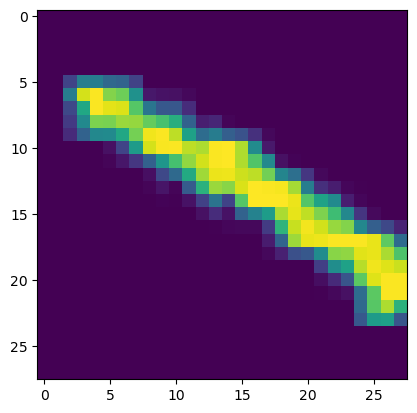

In [152]:
train_dataset = CustomDataset(
    dataframe=train,
    transforms=transforms.Compose([
      transforms.ToPILImage(),
      transforms.RandomRotation(30),
      transforms.RandomResizedCrop(28),
      transforms.RandomHorizontalFlip(),
      transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
      transforms.ToTensor(),
      transforms.Normalize(
        [0.485],
        [0.229]
      )
    ])
)

plt.imshow(train_dataset[0][0].reshape((28, 28, 1)))

In [153]:
train_sub, val_sub = data_setup.split_dataset(
    dataset=train_dataset,
    split_size=0.7,
    seed=42
)

class_names = train_dataset.classes
class_names

[INFO] Splitting dataset of length 42000 into splits of size: 29399 and 12601


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [158]:
learning_rate_list = [1e-4, 1e-5, 1e-6] # 각 LR 별로 50 epoch 씩 연달아 학습 진행
weight_decay_list = [1e-4]
epochs_list = [3]
batch_size_list = [16]

In [161]:
model = ResNet_mnist.Resnet_mnist(
    in_channels=1,
    num_classes=len(class_names)
)

summary(model)

Layer (type:depth-idx)                        Param #
Resnet_mnist                                  --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
├─Sequential: 1-2                             --
│    └─conv_residual_bottleneck: 2-4          --
│    │    └─Sequential: 3-1                   58,112
│    │    └─Sequential: 3-2                   16,896
│    └─conv_residual_bottleneck: 2-5          --
│    │    └─Sequential: 3-3                   70,400
│    └─conv_residual_bottleneck: 2-6          --
│    │    └─Sequential: 3-4                   70,400
│    └─conv_residual_bottleneck: 2-7          --
│    │    └─Sequential: 3-5                   70,400
│    └─conv_residual_bottleneck: 2-8          --
│    │    └─Sequential: 3-6                   70,400
├─Sequential: 1-3                             --
│    └─conv_residual_bottleneck: 2-9

In [162]:
tuning_results = engine.HP_tune_train(
    model=model,
    model_generator=None,
    model_weights=None,
    model_name='ResNet_mnist',
    train_dataset=train_sub,
    test_dataset=val_sub,
    learning_rate_list=learning_rate_list,
    weight_decay_list=weight_decay_list,
    epochs_list=epochs_list,
    batch_size_list=batch_size_list,
    is_tensorboard_writer=False,
    device=device,
    gradient_accumulation_num=1
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 1.5259, Train_acc: 0.4876 | Test_loss: 1.2990, Test_acc: 0.5875
Epoch: 1 | Train_loss: 1.0859, Train_acc: 0.6443 | Test_loss: 1.0140, Test_acc: 0.6692


KeyboardInterrupt: 